In [1]:
import pandas as pd
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline
import seaborn as sns

In [2]:
testesPI = ["9"]
testesSW = ["10"]
tempos = ["015", "025", "035"]
temposExp = ["399"]
seeds = ["10", "20"]
quantidadeIperfs = 2500
salvarGraficos = False
#0.15 ini=150 fim=250
#0.25 ini=200 fim=550
#0.35 ini=200 fim=800
iniEstavel = 0
fimEstavel = 999

In [3]:
#Lendo os arquivos info (report do controlador)
dfPI_info = pd.DataFrame()
dfSW_info = pd.DataFrame()
i = 1
for seed in seeds:
    for tempo in tempos:
        dfPI_infoTemp = pd.read_csv("../Saidas/teste"+(str(i))+"_pi"+(tempo)+"/info_parimpar.txt", sep=" ")
        dfPI_infoTemp['TempoChegada'] = tempo
        dfPI_infoTemp['Seed'] = seed
        dfPI_info = pd.concat([dfPI_info, dfPI_infoTemp], ignore_index=True)
        dfSW_infoTemp = pd.read_csv("../Saidas/teste"+(str(i))+"_sw"+(tempo)+"/info_sw.txt", sep=" ")
        dfSW_infoTemp['TempoChegada'] = tempo
        dfSW_infoTemp['Seed'] = seed
        dfSW_info = pd.concat([dfSW_info, dfSW_infoTemp], ignore_index=True)
    i += 1

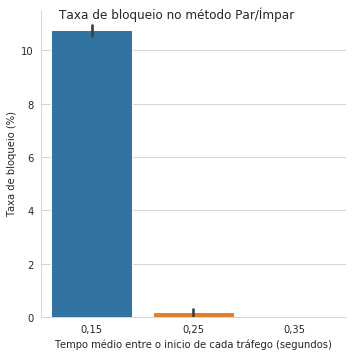

In [4]:
#Grafico de bloqueados metodo par impar
gpb = dfPI_info.groupby(["Seed", "TempoChegada"]).max()
gpb.reset_index(inplace=True)
gpb["TaxaBloqueio"] = gpb["RegrasBloqueadas"]/2/float(quantidadeIperfs)*100
sns.set_style("whitegrid")
sns_plt = sns.catplot(x="TempoChegada", y="TaxaBloqueio", kind="bar", ci=95, data=gpb)
sns_plt.fig.suptitle('Taxa de bloqueio no método Par/Ímpar')
sns_plt.set_axis_labels("Tempo médio entre o inicio de cada tráfego (segundos)", "Taxa de bloqueio (%)").set_xticklabels(["0,15", "0,25", "0,35"])
if (salvarGraficos):
    sns_plt.savefig("taxaBloqueio.pdf")

In [5]:
#Lendo todos os CSVs dos iperfs
dfPI_csv = pd.DataFrame()
dfSW_csv = pd.DataFrame()
i = 1
for seed in seeds:
    for tempo in tempos:
        dfPI_csvTemp = pd.read_csv("../Saidas/teste"+(str(i))+"_pi"+(tempo)+"/teste"+(str(i))+"_pi"+(tempo)+".csv")
        dfPI_csvTemp['TempoChegada'] = tempo
        dfPI_csvTemp['Seed'] = seed
        dfPI_csvTemp['Metodo'] = 'PI'
        dfPI_csv = pd.concat([dfPI_csv, dfPI_csvTemp], ignore_index=True)
        dfSW_csvTemp = pd.read_csv("../Saidas/teste"+(str(i))+"_sw"+(tempo)+"/teste"+(str(i))+"_sw"+(tempo)+".csv")
        dfSW_csvTemp['TempoChegada'] = tempo
        dfSW_csvTemp['Seed'] = seed
        dfSW_csvTemp['Metodo'] = 'SW'
        dfSW_csv = pd.concat([dfSW_csv, dfSW_csvTemp], ignore_index=True)
    i += 1
del dfPI_csv['?']
del dfSW_csv['?']
del dfSW_csv['Timestamp']
del dfPI_csv['Timestamp']
dfServerPI = dfPI_csv[dfPI_csv.IpOri == '10.1.0.1']
dfServerSW = dfSW_csv[dfSW_csv.IpOri == '10.1.0.1']
dfServer = pd.concat([dfServerPI, dfServerSW], ignore_index=True)

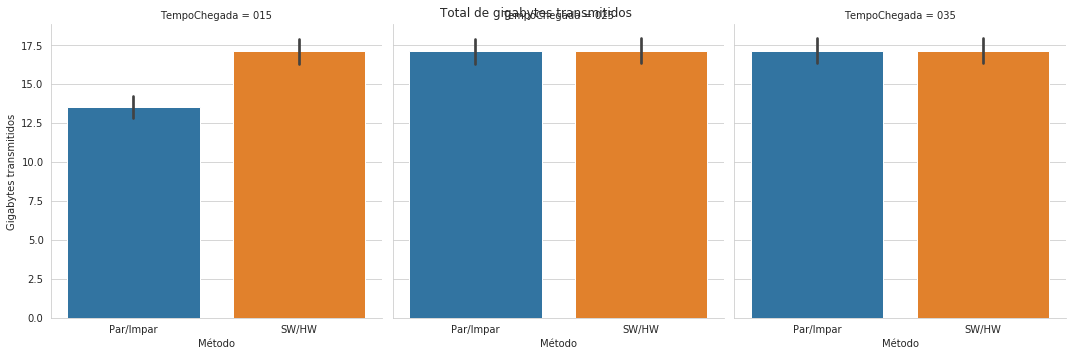

In [6]:
#Trafego total em cada metodo
gpb = dfServer.groupby(["Metodo","TempoChegada", "Seed"]).sum()
gpb["GBEnv"] = gpb["BytesEnv"]/1e9
gpb.reset_index(inplace=True)
sns.set_style("whitegrid")
sns_plt = sns.catplot(x="Metodo", y="GBEnv", kind="bar", ci=95, data=gpb, col="TempoChegada")
sns_plt.fig.suptitle('Total de gigabytes transmitidos')
sns_plt.set_axis_labels("Método", "Gigabytes transmitidos").set_xticklabels(["Par/Impar", "SW/HW"])
if (salvarGraficos):
    sns_plt.savefig("totalgbtransmitidos.pdf")

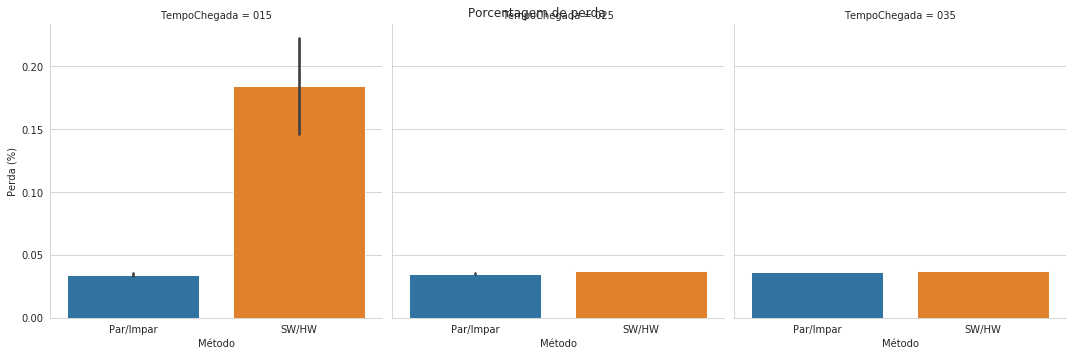

In [7]:
#Perda de pacotes total
gpb = dfServer.groupby(["Metodo", "TempoChegada", "Seed"]).sum()
gpb["PPerda"] = (gpb["PctPerdido"]/gpb["PctEnv"])*100
gpb.reset_index(inplace=True)
sns.set_style("whitegrid")
sns_plt = sns.catplot(x="Metodo", y="PPerda", kind="bar", ci=95, data=gpb, col="TempoChegada")
sns_plt.fig.suptitle('Porcentagem de perda')
sns_plt.set_axis_labels("Método", "Perda (%)").set_xticklabels(["Par/Impar", "SW/HW"])
if (salvarGraficos):
    sns_plt.savefig("totalPerda.pdf")

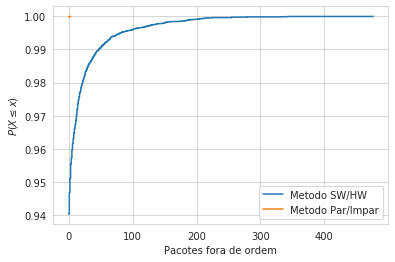

In [8]:
#CDF dos pacotes fora de ordem --- NÃO DIVIDE POR SEED
a = dfServerSW['ForaOrdem'].tolist()
b = dfServerPI['ForaOrdem'].tolist()
x = np.sort(a)
x1 = np.sort(b)
ecdf = sm.distributions.ECDF(a)
ecdf1 = sm.distributions.ECDF(b)
y = ecdf(x)
y1 = ecdf1(x1)
plt.step(x, y, where='post', label="Metodo SW/HW")
plt.step(x1, y1, where='post', label="Metodo Par/Impar")
plt.ylabel(r'$P(X \leq x)$')
plt.xlabel(r'Pacotes fora de ordem')
plt.legend()
if (salvarGraficos):
    plt.savefig('foraOrdem.pdf')
plt.show()